Representations:
* Individual tree
* Trajectory
    * Radii vs. iteration, with summaries such as log-probability, and the marginal likelihoods of various models
    * Include SMIRKS tags for the individual types

In [1]:
from pickle import load
from glob import glob
glob('../bayes_implicit_solvent/rjmc_experiments/tree_rjmc_run_*.pkl')

['../bayes_implicit_solvent/rjmc_experiments/tree_rjmc_run_642.pkl',
 '../bayes_implicit_solvent/rjmc_experiments/tree_rjmc_run_321.pkl',
 '../bayes_implicit_solvent/rjmc_experiments/tree_rjmc_run_64.pkl']

In [2]:
with open('../bayes_implicit_solvent/rjmc_experiments/tree_rjmc_run_64.pkl', 'rb') as f:
    result = load(f)

using the following decorators:
['~[#1]', '~[#6]', '~[#7]', '~[#8]', '~[#9]', '~[#15]', '~[#16]', '~[#17]', '~[#35]', '~[#53]']


In [3]:
result.keys()

dict_keys(['traj', 'log_probs', 'log_acceptance_probabilities'])

In [4]:
traj = result['traj']
log_probs = result['log_probs']
log_acceptance_probabilities = result['log_acceptance_probabilities']

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0, 0.5, 'log probability')

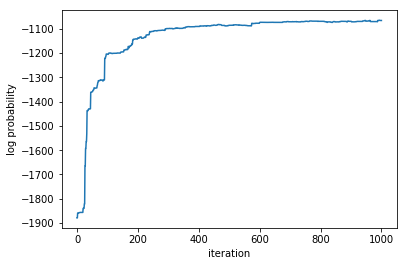

In [6]:
plt.plot(log_probs)
plt.xlabel('iteration')
plt.ylabel('log probability')

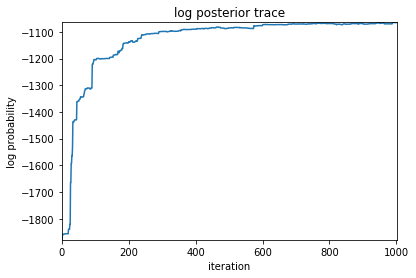

In [7]:
def plot_log_prob(t=1000):
    
    plt.xlim(0, len(log_probs))
    plt.ylim(min(log_probs), max(log_probs))
    plt.plot(log_probs[:t])
    plt.xlabel('iteration')
    plt.ylabel('log probability')
    
    plt.title('log posterior trace')
plot_log_prob()

In [8]:
tree = traj[0]

Text(0.5, 0, 'iteration')

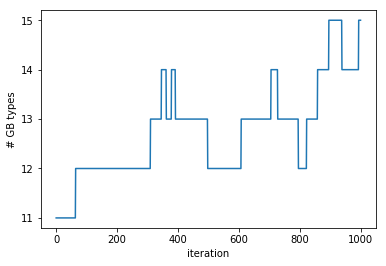

In [9]:
n_types = [tree.number_of_nodes for tree in traj]
plt.plot(n_types)
plt.yticks(list(range(min(n_types), max(n_types) + 1)))
plt.ylabel('# GB types')
plt.xlabel('iteration')

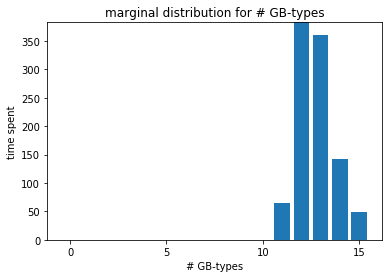

In [10]:
import numpy as np


def plot_running_average_model_evidence(t=1000):
    x = list(range(0, max(n_types) + 1))
    y = np.bincount(n_types[:t], minlength=len(x))
    
    plt.bar(x, y)
    plt.xlabel('# GB-types')
    plt.ylabel('time spent')
    plt.title('marginal distribution for # GB-types')
    
    plt.xticks(list(range(max(n_types) + 1))[::5])
    
    plt.ylim(0,max(np.bincount(n_types)))
plot_running_average_model_evidence()

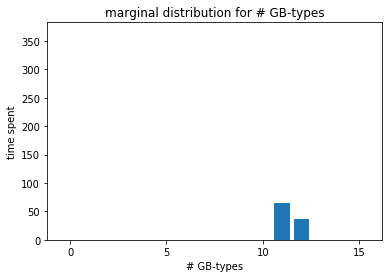

In [11]:
plot_running_average_model_evidence(100)

In [12]:
tree = traj[-1]

In [13]:
from simtk import unit

radii = np.array([tree.get_radius(n) / unit.nanometer for n in tree.ordered_nodes])

In [14]:
list(zip(tree.ordered_nodes, radii))

[('*', 0.1825982973132233),
 ('[#1]', 0.054763903661834715),
 ('[#6]', 0.15803113872414137),
 ('[#8]', 0.17312303628095052),
 ('[#15]', 0.21744975341765016),
 ('[#17]', 0.15924016441169084),
 ('[#35]', 0.20430179402346277),
 ('[#53]', 0.11004330301513611),
 ('[#1]~[#53]', 0.028934837390646152),
 ('[#8]~[#53]', 0.30660173621339454),
 ('[#15]~[#53]', 0.20714303764692493),
 ('[#17]~[#1]', 0.16373504155776902),
 ('[#53]~[#15]', 0.0883507471588251),
 ('[#53]~[#6]', 0.2128398256226872),
 ('[#53]~[#15]~[#16]', 0.08515222847351464)]

In [15]:
# to assign colors, let's get all of the types every encountered during the simulation
# then put them in lexicographic order, then make a dictionary that indexes into a nice seaborn color palette

In [16]:
all_types = set()
for tree in traj:
    all_types.update(tree.ordered_nodes)
all_types = sorted(list(all_types))

In [17]:
all_types

['*',
 '[#15]',
 '[#15]~[#53]',
 '[#16]',
 '[#16]~[#9]',
 '[#17]',
 '[#17]~[#1]',
 '[#1]',
 '[#1]~[#53]',
 '[#35]',
 '[#53]',
 '[#53]~[#15]',
 '[#53]~[#15]~[#16]',
 '[#53]~[#6]',
 '[#6]',
 '[#7]',
 '[#8]',
 '[#8]~[#53]',
 '[#8]~[#53]~[#1]',
 '[#8]~[#7]',
 '[#9]']

In [18]:
len(all_types)

21

In [19]:
import seaborn.apionly as sns
color_list = sns.color_palette(palette="husl", n_colors=len(all_types))
color_list = color_list[5:] + color_list[:5]
color_dict = dict(zip(all_types, color_list))

/Users/joshuafass/anaconda/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)
/Users/joshuafass/anaconda/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [20]:
x = []
y = []
c = []

for i in range(len(traj)):
    tree = traj[i]
    radii = [tree.get_radius(n) / unit.nanometer for n in tree.ordered_nodes]
    
    x += [i] * len(radii)
    y += radii
    c += [color_dict[t] for t in tree.ordered_nodes]

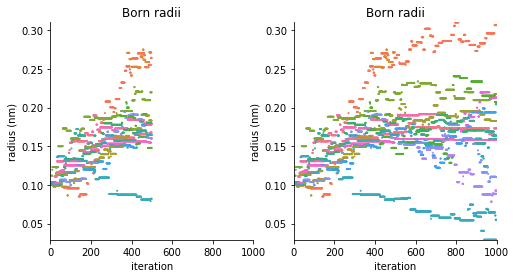

In [21]:
def plot_radii(ax, up_to_iteration=1000):
    
    t = np.argmax(np.array(x) >= up_to_iteration)
    
    ax.scatter(x[:t], y[:t], s=1, color=c[:t])
    ax.set_xlim(0, len(traj))
    ax.set_ylim(min(y), max(y))
    ax.set_xlabel('iteration')
    ax.set_ylabel('radius (nm)')
    
    ax.set_title('Born radii')
    

def prettify_axes(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.figure(figsize=(8,4))
ax = plt.subplot(1,2,1)
plot_radii(ax, 500)
prettify_axes(ax)

ax = plt.subplot(1,2,2)
plot_radii(ax)
prettify_axes(ax)

In [22]:
node_color = [color_dict[n] for n in tree.G.nodes()]
import networkx as nx

In [23]:
layouts = [
    ('shell', nx.layout.shell_layout(tree.G)),
    ('fruchterman_reingold', nx.layout.fruchterman_reingold_layout(tree.G)),
    ('kamada_kawai', nx.layout.kamada_kawai_layout(tree.G)),
    ('spectral', nx.layout.spectral_layout(tree.G)),
    ('circular', nx.layout.circular_layout(tree.G)),
]

/Users/joshuafass/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:565: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


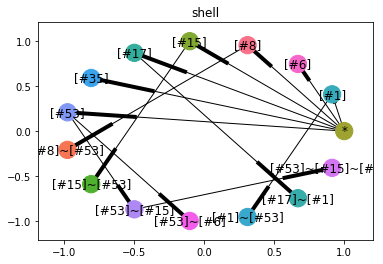

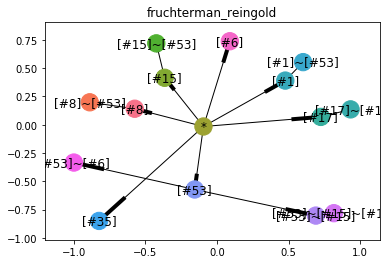

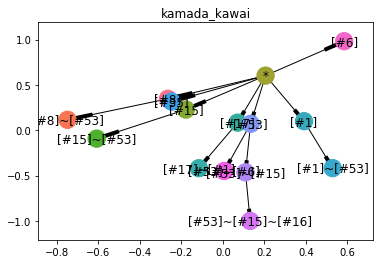

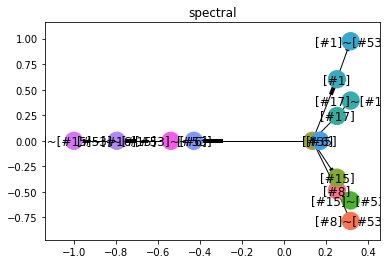

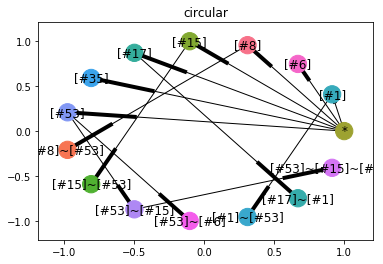

In [24]:
for name, pos in layouts:
    plt.figure()
    plt.title(name)
    nx.draw_networkx(tree.G, pos=pos, node_color=node_color, )

In [25]:
# none of these are what I want!

In [26]:
# let's just precompute sensible positions for all of the types

In [27]:
def depth(node):
    if node == '*':
        return 0
    return len(node.split('~'))

In [28]:
depth_dict = dict(zip(all_types, map(depth, all_types)))

In [29]:
depth_dict

{'*': 0,
 '[#15]': 1,
 '[#15]~[#53]': 2,
 '[#16]': 1,
 '[#16]~[#9]': 2,
 '[#17]': 1,
 '[#17]~[#1]': 2,
 '[#1]': 1,
 '[#1]~[#53]': 2,
 '[#35]': 1,
 '[#53]': 1,
 '[#53]~[#15]': 2,
 '[#53]~[#15]~[#16]': 3,
 '[#53]~[#6]': 2,
 '[#6]': 1,
 '[#7]': 1,
 '[#8]': 1,
 '[#8]~[#53]': 2,
 '[#8]~[#53]~[#1]': 3,
 '[#8]~[#7]': 2,
 '[#9]': 1}

In [30]:
height_dict = dict(zip(all_types, 0.3 * np.arange(len(all_types))))
height_dict

{'*': 0.0,
 '[#15]': 0.3,
 '[#15]~[#53]': 0.6,
 '[#16]': 0.8999999999999999,
 '[#16]~[#9]': 1.2,
 '[#17]': 1.5,
 '[#17]~[#1]': 1.7999999999999998,
 '[#1]': 2.1,
 '[#1]~[#53]': 2.4,
 '[#35]': 2.6999999999999997,
 '[#53]': 3.0,
 '[#53]~[#15]': 3.3,
 '[#53]~[#15]~[#16]': 3.5999999999999996,
 '[#53]~[#6]': 3.9,
 '[#6]': 4.2,
 '[#7]': 4.5,
 '[#8]': 4.8,
 '[#8]~[#53]': 5.1,
 '[#8]~[#53]~[#1]': 5.3999999999999995,
 '[#8]~[#7]': 5.7,
 '[#9]': 6.0}

In [31]:
pos_dict = dict(zip(all_types, [(depth_dict[t], height_dict[t]) for t in all_types]))
pos_dict

{'*': (0, 0.0),
 '[#15]': (1, 0.3),
 '[#15]~[#53]': (2, 0.6),
 '[#16]': (1, 0.8999999999999999),
 '[#16]~[#9]': (2, 1.2),
 '[#17]': (1, 1.5),
 '[#17]~[#1]': (2, 1.7999999999999998),
 '[#1]': (1, 2.1),
 '[#1]~[#53]': (2, 2.4),
 '[#35]': (1, 2.6999999999999997),
 '[#53]': (1, 3.0),
 '[#53]~[#15]': (2, 3.3),
 '[#53]~[#15]~[#16]': (3, 3.5999999999999996),
 '[#53]~[#6]': (2, 3.9),
 '[#6]': (1, 4.2),
 '[#7]': (1, 4.5),
 '[#8]': (1, 4.8),
 '[#8]~[#53]': (2, 5.1),
 '[#8]~[#53]~[#1]': (3, 5.3999999999999995),
 '[#8]~[#7]': (2, 5.7),
 '[#9]': (1, 6.0)}

/Users/joshuafass/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:565: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


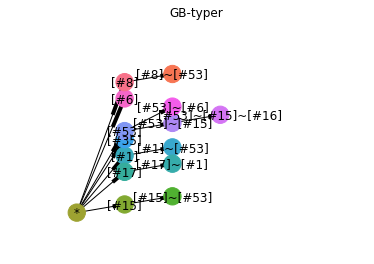

In [32]:
def draw_typing_tree(tree):
    node_color = [color_dict[n] for n in tree.G.nodes()]
    nx.draw_networkx(tree.G, pos=pos_dict, node_color=node_color)
    plt.xlim(-1,6)
    plt.ylim(-1,7)
    #plt.xticks([])
    #plt.yticks([])
    plt.axis('off')
    plt.title('GB-typer')
draw_typing_tree(traj[-1])

In [33]:
def plot_summary(t=1000):
    plt.figure(figsize=(8,8))
    
    # 1. current tree
    ax = plt.subplot(2,2,1)
    tree = traj[t]
    draw_typing_tree(tree)
    
    # 2. radii
    ax = plt.subplot(2,2,2)
    plot_radii(ax, t)
    prettify_axes(ax)

    # 3. log probability
    ax = plt.subplot(2,2,3)
    plot_log_prob(t)
    prettify_axes(ax)
    
    
    # 4. marginal # GB types
    ax = plt.subplot(2,2,4)
    plot_running_average_model_evidence(t)
    prettify_axes(ax)
    
    # (# types trajectory?)
    
    plt.tight_layout()

/Users/joshuafass/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:565: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


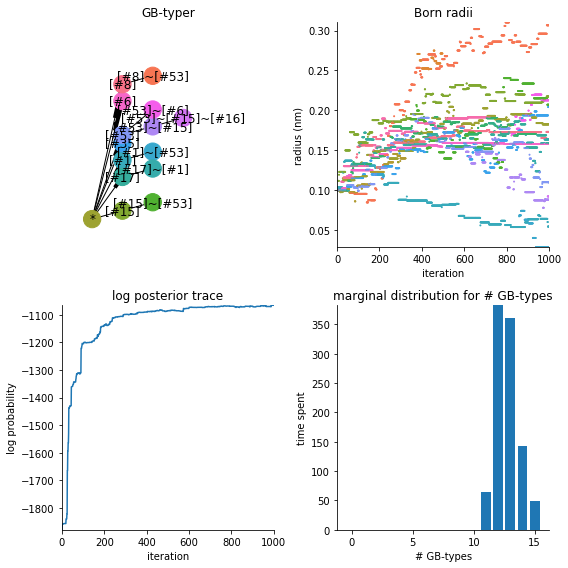

In [34]:
plot_summary(1000)

In [35]:
len(traj)

1001

/Users/joshuafass/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:565: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


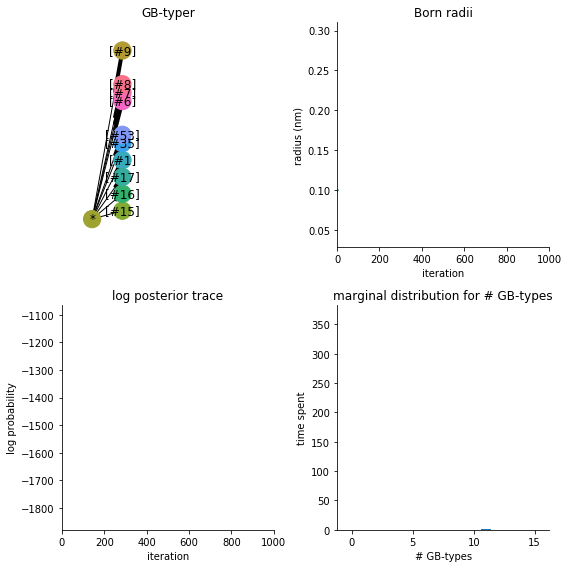

In [36]:
plot_summary(2)

In [37]:
from tqdm import tqdm
for t in tqdm(range(2, len(traj))[::10]):
    plot_summary(t)
    plt.savefig('typing_animation/{:03}.png'.format(t))
    plt.close()

  0%|          | 0/100 [00:00<?, ?it/s]/Users/joshuafass/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:565: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
100%|██████████| 100/100 [01:56<00:00,  1.16s/it]
